# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


In [56]:
import math
import re
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from functools import reduce
from tqdm import *

url = "https://www.topuniversities.com"


#https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/100/sort_by/rank/sort_order/asc/cols/stats

## Part1  For  www.topuniversities.com

In [57]:
def detail_per_uni(urls) :
    
    soup = BeautifulSoup(urls.text,"html.parser")
    
    total_faculty  = soup.find('div',class_='total faculty')
    
    tf = 0
    ts = 0 
    ti = 0 
    
    if(total_faculty != None) :
        total_faculty = total_faculty.find('div',class_='number').text
        total_student = soup.find('div',class_='total student').find('div',class_='number').text
        total_international = soup.find('div',class_ = 'total inter').find('div',class_='number').text
        tf = int(total_faculty[1:-1].replace(',',''))
        ts = int(total_student[1:-1].replace(',',''))
        ti = int(total_international[1:-1].replace(',',''))
    else :
        #if the data isn't availble on the site
        tf = 0
        ts = 0
        ti = 0
    return {'Total faculty members': tf, 'Total students':ts,'International students':ti}

def scrape_uni_detail(urls):
    parsed_url = []
    
    for i,url in enumerate(tqdm_notebook(urls)) : 
        parsed_url.append(detail_per_uni(url))
        #print("progress ",i)

    return parsed_url

In [58]:
#This checks if a certain string begins with '='
def noequals(x) :
    return None==re.match('(=)\w+', x) 

In [59]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508105606999')

data= dict(json.loads(r.text))

data= pd.DataFrame(data['data'])[['title','rank_display','region','country','url']]

data.columns = ['University','Ranking', 'Region','Country','URL']
data.Ranking = data.Ranking.apply(lambda r : str(r))

rankings = list(data.Ranking)
#we clean the ranking column so that we don't have equals
rankings =  pd.Series([r if noequals(r) else r[1:] for r in rankings])

data['Ranking'] = rankings



In [ ]:
urls = []

for i in tqdm_notebook(range(100)): 
    urls.append(requests.get(url+data.URL[i]))

In [ ]:
for i in tqdm_notebook(range(100,200)):
    urls.append(requests.get(url+data.URL[i]))


In [62]:
details_uni = scrape_uni_detail(urls)



HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

In [63]:
details_uni = pd.DataFrame(details_uni)

d = data.copy()
d = d.loc[:199]
d = d.drop('URL',axis=1)

final_data = pd.concat([d,details_uni],axis=1)
#final_data =final_data.set_index('University')

## Sanity check for unique index

In [64]:
final_data.index.is_unique

True

In [65]:
final_data

,University,Ranking,Region,Country,International students,Total faculty members,Total students
0,Massachusetts Institute of Technology (MIT),1,North America,United States,3717,2982,11067
1,Stanford University,2,North America,United States,3611,4285,15878
2,Harvard University,3,North America,United States,5266,4350,22429
3,California Institute of Technology (Caltech),4,North America,United States,647,953,2255
4,University of Cambridge,5,Europe,United Kingdom,6699,5490,18770
5,University of Oxford,6,Europe,United Kingdom,7353,6750,19720
6,UCL (University College London),7,Europe,United Kingdom,14854,6345,31080
7,Imperial College London,8,Europe,United Kingdom,8746,3930,16090
8,University of Chicago,9,North America,United States,3379,2449,13557
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,Switzerland,7563,2477,19815


## Part 2 
## Which are the best universities in term of: (a) ratio between faculty members and students,  (b) ratio of international students?

In [66]:
#Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?


final_data['Ratio faculty members and students'] = final_data['Total faculty members']/final_data['Total students']
final_data['Ratio faculty members and international students'] = final_data['Total faculty members']/final_data['International students']

ratio_faculty_intern_max = final_data['Ratio faculty members and international students'].idxmax()
ratio_faculty_total_students = final_data['Ratio faculty members and students'].idxmax()
#final_data.loc[final_data['Ratio faculty members and international students'] == number]

In [67]:
(pd.DataFrame(final_data.loc[ratio_faculty_intern_max]).T)

,University,Ranking,Region,Country,International students,Total faculty members,Total students,Ratio faculty members and students,Ratio faculty members and international students
179,Indian Institute of Technology Bombay (IITB),179,Asia,India,93,876,9402,0.0931717,9.41935


In [68]:
pd.DataFrame(final_data.loc[ratio_faculty_total_students]).T

,University,Ranking,Region,Country,International students,Total faculty members,Total students,Ratio faculty members and students,Ratio faculty members and international students
3,California Institute of Technology (Caltech),4,North America,United States,647,953,2255,0.422616,1.47295


## Part 3 
## Answer the previous question aggregating the data by (c) country and (d) region.

In [69]:
# we just perfom a simply groupby action to do the aggregrate

def get_aggregate_data(column,final_data,groupby) :

    final_data_grouped_region = final_data.sort_values([column],ascending=False).groupby([groupby])

    dataframe = []
    for region,df in (final_data_grouped_region) :
        dataframe.append(pd.DataFrame(df.iloc[0]).T)

    final_data_grouped_region = (reduce(lambda a,b : pd.concat([a,b],axis=0),dataframe ))

    return final_data_grouped_region



## Part C

In [70]:
get_aggregate_data('Ratio faculty members and international students',final_data,'Country').reset_index().set_index('Country')

,index,University,Ranking,Region,International students,Total faculty members,Total students,Ratio faculty members and students,Ratio faculty members and international students
Country,,,,,,,,,
Argentina,74,Universidad de Buenos Aires (UBA),75,Latin America,27109,16421,122301,0.134267,0.60574
Australia,93,The University of Western Australia,93,Oceania,4575,1420,18531,0.0766284,0.310383
Austria,153,University of Vienna,154,Europe,14468,3411,45967,0.0742054,0.235762
Belgium,181,Vrije Universiteit Brussel (VUB),182,Europe,1853,1792,9284,0.19302,0.96708
Brazil,120,Universidade de São Paulo,121,Latin America,2086,5582,65711,0.0849477,2.67593
Canada,139,McMaster University,140,North America,3548,3231,23702,0.136318,0.910654
Chile,138,Pontificia Universidad Católica de Chile (UC),137,Latin America,991,2260,27003,0.0836944,2.28052
China,96,University of Science and Technology of China,97,Asia,548,1992,16032,0.124251,3.63504
Denmark,73,University of Copenhagen,73,Europe,3683,7483,32119,0.232977,2.03177


In [71]:
get_aggregate_data('Ratio faculty members and students',final_data,'Country').reset_index().set_index('Country')

,index,University,Ranking,Region,International students,Total faculty members,Total students,Ratio faculty members and students,Ratio faculty members and international students
Country,,,,,,,,,
Argentina,74,Universidad de Buenos Aires (UBA),75,Latin America,27109,16421,122301,0.134267,0.60574
Australia,19,The Australian National University,20,Oceania,5551,1600,14442,0.110788,0.288236
Austria,153,University of Vienna,154,Europe,14468,3411,45967,0.0742054,0.235762
Belgium,181,Vrije Universiteit Brussel (VUB),182,Europe,1853,1792,9284,0.19302,0.96708
Brazil,120,Universidade de São Paulo,121,Latin America,2086,5582,65711,0.0849477,2.67593
Canada,139,McMaster University,140,North America,3548,3231,23702,0.136318,0.910654
Chile,138,Pontificia Universidad Católica de Chile (UC),137,Latin America,991,2260,27003,0.0836944,2.28052
China,24,Tsinghua University,25,Asia,4072,5506,36300,0.15168,1.35216
Denmark,116,Technical University of Denmark,116,Europe,2098,2117,8878,0.238455,1.00906


## Part D 

## Ratio of faculty members and students per Region

In [72]:
get_aggregate_data('Ratio faculty members and students',final_data,'Region').set_index('Region')

,University,Ranking,Country,International students,Total faculty members,Total students,Ratio faculty members and students,Ratio faculty members and international students
Region,,,,,,,,
Africa,University of Cape Town,191,South Africa,3325,1733,19593,0.08845,0.521203
Asia,Pohang University of Science And Technology (P...,71,South Korea,126,664,3117,0.213025,5.26984
Europe,University of Oxford,6,United Kingdom,7353,6750,19720,0.342292,0.917993
Latin America,Instituto Tecnológico y de Estudios Superiores...,199,Mexico,1412,1822,13376,0.136214,1.29037
North America,California Institute of Technology (Caltech),4,United States,647,953,2255,0.422616,1.47295
Oceania,The Australian National University,20,Australia,5551,1600,14442,0.110788,0.288236


## Ratio of faculty members and international students per Region

In [73]:
get_aggregate_data('Ratio faculty members and international students',final_data,'Region').set_index('Region')

,University,Ranking,Country,International students,Total faculty members,Total students,Ratio faculty members and students,Ratio faculty members and international students
Region,,,,,,,,
Africa,University of Cape Town,191,South Africa,3325,1733,19593,0.08845,0.521203
Asia,Indian Institute of Technology Bombay (IITB),179,India,93,876,9402,0.0931717,9.41935
Europe,University of Helsinki,102,Finland,1234,2645,22419,0.11798,2.14344
Latin America,Universidad Nacional Autónoma de México (UNAM),122,Mexico,2173,15073,141939,0.106194,6.93649
North America,"University of North Carolina, Chapel Hill",80,United States,1934,4083,25373,0.160919,2.11117
Oceania,University of Otago,151,New Zealand,3871,1266,18532,0.0683143,0.327047


## Scraping: timeshighereducation.com
Assumptions
- We are using [this site](https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/-1/sort_by/rank/sort_order/asc/cols/stats) which contains the rankings of 2018.
- Rank saved within `<td class="rank ..."><td>` element
- University saved within `<a href="..." class="ranking-institution-title ..."></a>` element
- Country saved within `<div class="location"></div>` element

First, the the data returned in the json file returned in the `GET` request are imported and Universities that are not within the top 200 are removed

In [74]:
def loadData(URL):
    # make a request
    r = requests.get(URL)
    r = r.json()
    # parse HTML with BeautifulSoup
    df=pd.DataFrame(r['data'])
    return df
    
URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
df=loadData(URL)
print(df.columns)
display(df.head())

Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')


,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


We do not need all columns, thus we extract only the ones relevant to the data we are looking for: _name, rank, country and region, number of faculty members (international and total) and number of students (international and total)._

These columns are derived as follows:
- `name`: column `name`
- `country`: `location`
- `region`: in detail URL?
- `number of faculty members (international)`: ?
- `number of faculty members (total)`: `stats_number_students` times `stats_student_staff_ratio`
- `number of students (international)`: `stats_number_students` times `stats_pc_intl_students`
- `number of students (total)`: `stats_number_students`

We first have to do some data cleanup:
- remove equal sign (`=`) in field `rank` (Universities having the same rank) and removing universities having a rank above 200
-  convert percentage of students in field `stats_pc_intl_students` (e.g. 83%) to float (e.g., 0.83) for multiplication
- Remove commas and cast to  type `int` for column `stats_number_students` ("number of students")

In [75]:
df=loadData(URL)
columns=["name","rank","location","stats_number_students","stats_student_staff_ratio",
         "stats_pc_intl_students","nid"]
columns_new_names=["name","rank","country","n_students","ratio_student_staff","pc_students_int","nid"]

df=df[columns]
df.columns=(columns_new_names)
# Data cleanup
df["rank"]=df["rank"].str.replace('=','')
df=df[np.isin(df["rank"],
              ["1001+","201–250","251–300","301–350","351–400","401–500","501–600","601–800","801–1000"],
              invert=True)]
df["rank"]=df["rank"].astype(int)

# convert percentage (e.g. 83%) to float (e.g., 0.83) for multiplication
def divide(x, n = 100):
    return float(x)/n
df["pc_students_int"] = df["pc_students_int"].str.replace('%','').apply(divide,n=100)

df["ratio_student_staff"] = df["ratio_student_staff"].str.replace(',','').astype(float)

# clean up: stats on number of students
df["n_students"]=df["n_students"].str.replace(',','').astype(int)
df.head()

,name,rank,country,n_students,ratio_student_staff,pc_students_int,nid
0,University of Oxford,1,United Kingdom,20409,11.2,0.38,468
1,University of Cambridge,2,United Kingdom,18389,10.9,0.35,470
2,California Institute of Technology,3,United States,2209,6.5,0.27,128779
3,Stanford University,3,United States,15845,7.5,0.22,467
4,Massachusetts Institute of Technology,5,United States,11177,8.7,0.34,471


We can now derive new columns for the missing data fields based on the existing columns.

In [76]:
# derived columns
df["n_staff"]=np.round(df["n_students"]/(df["ratio_student_staff"])).astype(int)
df["n_students_int"]=np.round(df["n_students"]*(df["pc_students_int"])).astype(int)
#df["ratio_staff_student"]=df["ratio_student_staff"]**-1
display(df.head())

,name,rank,country,n_students,ratio_student_staff,pc_students_int,nid,n_staff,n_students_int
0,University of Oxford,1,United Kingdom,20409,11.2,0.38,468,1822,7755
1,University of Cambridge,2,United Kingdom,18389,10.9,0.35,470,1687,6436
2,California Institute of Technology,3,United States,2209,6.5,0.27,128779,340,596
3,Stanford University,3,United States,15845,7.5,0.22,467,2113,3486
4,Massachusetts Institute of Technology,5,United States,11177,8.7,0.34,471,1285,3800


## Ranking aggregation
We can now answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.
Plot your data using bar charts and describe briefly what you observed.

In [ ]:
df_ratio_ss=df.sort_values(by=['ratio_student_staff']).head(10)
df_ratio_ss

,name,rank,country,n_students,ratio_student_staff,pc_students_int,nid,n_staff,n_students_int
105,Vanderbilt University,105,United States,12011,3.3,0.13,534,3640,1561
109,University of Copenhagen,109,Denmark,30395,4.1,0.14,599,7413,4255
12,Johns Hopkins University,13,United States,15498,4.3,0.24,478,3604,3720
11,Yale University,12,United States,12155,4.3,0.21,475,2827,2553
153,University of Rochester,153,United States,9636,4.3,0.29,545,2241,2794
97,Emory University,98,United States,12649,4.4,0.19,539,2875,2403
16,Duke University,17,United States,15256,4.5,0.22,487,3390,3356
114,École Polytechnique,115,France,2799,5.1,0.36,527,549,1008
183,Scuola Normale Superiore di Pisa,184,Italy,515,5.2,0.07,1019,99,36
101,University of Pittsburgh,100,United States,26367,5.9,0.10,524,4469,2637


In [150]:
def plot_histogram(df, x, y, title, xlab, figsize=(20,10)):
    """
    This functions plots a histogram adding the values on top of the bins.
    
    df: dataframe
    x: column name for x axis
    y: column name for y axis
    title: title to give to the histogram
    xlab: xlabel
    """
    x=df[x].values
    y=np.round(df[y],2)
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.5 # the width of the bars
    ind = np.arange(len(y))  # the x locations for the groups
    ax.bar(ind, y, width, color="red")
    ax.set_xticks(ind)
    ax.set_xticklabels(x, rotation=90)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(title)
    for i, v in enumerate(y):
        
        ax.text(i-width/2, v*1.02, str(v), color='red')

    plt.show()

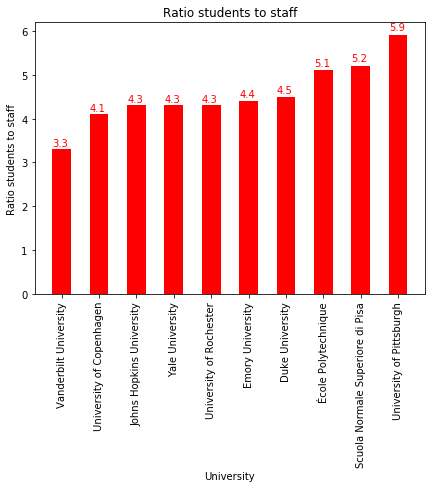

In [151]:
plot_histogram(df_ratio_ss,"name","ratio_student_staff", title='Ratio students to staff',
               xlab='University', figsize=(7,5))

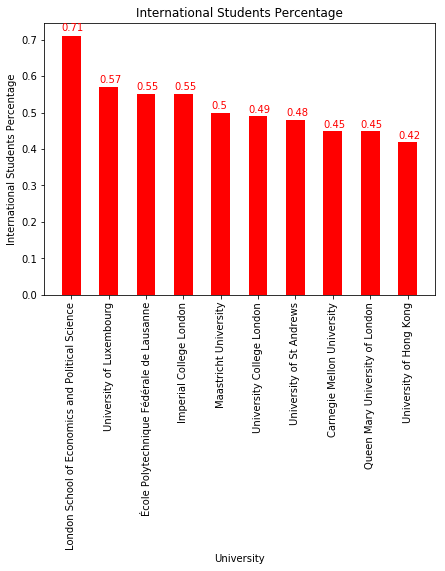

In [152]:
# ratio of international students
df_ratio_is=df.sort_values(ascending=False,by=['pc_students_int']).head(10)
df_ratio_is
plot_histogram(df_ratio_is,"name","pc_students_int", title='International Students Percentage',
               xlab='University', figsize=(7,5))

## Aggregated: by country
Now, let's plot the same results aggregated by country.

In [157]:
df_c_ratio_ss=df.groupby("country").mean().sort_values(ascending=False,by=['ratio_student_staff']).head(10)
df_c_ratio_ss.reset_index(inplace=True)

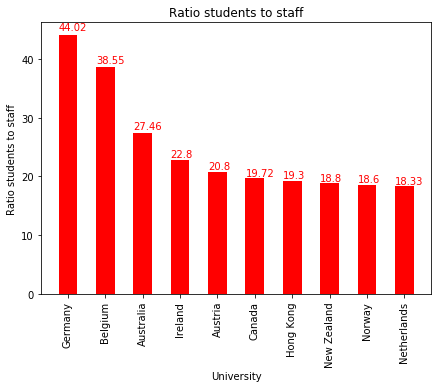

In [158]:
plot_histogram(df_c_ratio_ss,"country","ratio_student_staff", title='Ratio students to staff',
               xlab='University', figsize=(7,5))

In [159]:
df_c_ratio_is=df.groupby("country").mean().sort_values(ascending=False,by=['pc_students_int']).head(10)
df_c_ratio_is.reset_index(inplace=True)

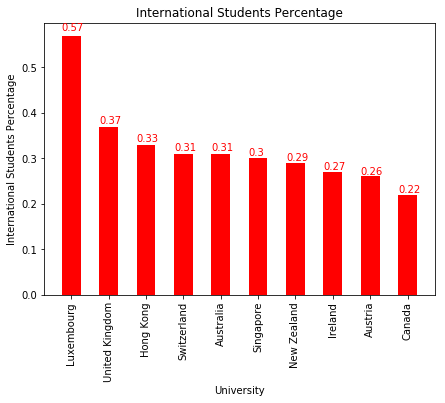

In [160]:
plot_histogram(df_c_ratio_is,"country","pc_students_int", title='International Students Percentage',
               xlab='University', figsize=(7,5))